# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms

# Constants definition

In [2]:
EPOCHS = 20
IMAGE_SIZE = 28
# Keras's default learning rate is 1e-3
LEARNING_RATE = 1e-3
# Keras's default batch size is 32
BATCH_SIZE = 32
NUM_WORKERS = 4

In [3]:
# use GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Define functions

In [4]:
def fit(model, optimizer, loss_fn, train_data, device=torch.device('cpu'), epochs=5):
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        loss_sum = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            out = model(images)
            loss = loss_fn(out, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(out.data, 1)            
            total += images.size(0)
            correct += (predicted == labels).sum().item()
            loss_sum += loss.item()
            
        acc = correct / total
        print(f'loss: {loss_sum / len(train_loader):e} - acc: {acc}')
        
        if acc > 0.998:
            print('Reached 99.8% accuracy so cancelling training!')
            break

In [5]:
def evaluate(model, test_data, device=torch.device('cpu')):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_data:
            out = model(images.to(device))
            _, predicted = torch.max(out.data, 1)
            total += images.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    print(f'Test accuracy: {100 * correct / total}%')

# Providing the data

In [6]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('../data/fashionMNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data/fashionMNIST', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Fit and Evaluate the Neural Network

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 32, (3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Flatten(),
    nn.Linear(13 * 13 * 32, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(DEVICE)

print(model)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

fit(model, optimizer, loss_fn, train_loader, device=DEVICE, epochs=EPOCHS)
evaluate(model, test_loader, device=DEVICE)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=5408, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/20
loss: 1.828207e-01 - acc: 0.9454833333333333
Epoch 2/20
loss: 6.040317e-02 - acc: 0.9817166666666667
Epoch 3/20
loss: 3.865861e-02 - acc: 0.98815
Epoch 4/20
loss: 2.683064e-02 - acc: 0.9912833333333333
Epoch 5/20
loss: 1.846186e-02 - acc: 0.9938166666666667
Epoch 6/20
loss: 1.377801e-02 - acc: 0.9956333333333334
Epoch 7/20
loss: 8.374845e-03 - acc: 0.9974
Epoch 8/20
loss: 7.224003e-03 - acc: 0.9978333333333333
Epoch 9/20
loss: 5.792481e-03 - acc: 0.99825
Reached 99.8% accuracy so cancelling training!
Test accuracy: 98.52%


# Visualizing the Convolutions and Pooling

In [8]:
print(test_dataset.targets[:100])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9])


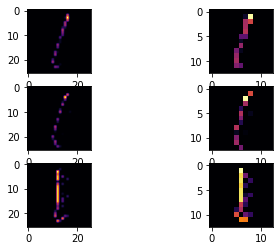

In [9]:
import matplotlib.pyplot as plt

def get_forward_hook(ax, x, y, cn):
    def hook(model, input, output):
        ax[x,y].imshow(output.detach().cpu()[0, cn, : , :], cmap='inferno')
        ax[x,y].grid(False)
    return hook

f, axarr = plt.subplots(3,2)
FIRST_IMAGE=2
SECOND_IMAGE=5
THIRD_IMAGE=14
CONVOLUTION_NUMBER = 1
with torch.no_grad():
    for i, x in enumerate([1, 2]):
        handle = model[x].register_forward_hook(get_forward_hook(axarr, 0, i, CONVOLUTION_NUMBER))
        model(test_dataset[FIRST_IMAGE][0].reshape(1, 1, 28, 28).to(DEVICE))
        handle.remove()
        
        handle = model[x].register_forward_hook(get_forward_hook(axarr, 1, i, CONVOLUTION_NUMBER))
        model(test_dataset[SECOND_IMAGE][0].reshape(1, 1, 28, 28).to(DEVICE))
        handle.remove()
        
        handle = model[x].register_forward_hook(get_forward_hook(axarr, 2, i, CONVOLUTION_NUMBER))
        model(test_dataset[THIRD_IMAGE][0].reshape(1, 1, 28, 28).to(DEVICE))
        handle.remove()